In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# Initialize CUDA
use_cuda = True

cuda_available = torch.cuda.is_available()
USE_CUDA = use_cuda and cuda_available

print("Cuda available: ", cuda_available)
print("Using Cuda:     ", USE_CUDA)

if cuda_available:
    print(torch.cuda.get_device_name(0))
    cuda_device = torch.device("cuda:0")

Cuda available:  True
Using Cuda:      True
NVIDIA GeForce RTX 3060


In [2]:
# Root directory for dataset
dataroot = "processed"

# Batch size during training
batch_size = 512

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_w = 463
image_h = 109

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mo
ngpu = 1

In [3]:
from os import listdir
from os.path import isfile, join
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

onlyfiles = [f for f in listdir(dataroot) if isfile(join(dataroot, f))]

sample_count = 0
for file in onlyfiles:
    if ".png" in file:
        sample_count += 1

new_width = 512
new_height = 128
dataset = np.zeros((sample_count, new_height, new_width, 3), dtype = np.float32)
i = 0

for file in onlyfiles:
    if ".png" in file:
        img = Image.open(dataroot + "/" + file).resize((new_width, new_height), Image.Resampling.LANCZOS)

        dataset[i, :, :, :] = np.array(img) / 255
        # plt.imshow(dataset[i])
        # plt.show()
        i += 1

In [4]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
        
#         self.step0  = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
#         self.step1  = nn.BatchNorm2d(ngf * 8)
#         self.step2  = nn.ReLU(True)
#         self.step3  = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
#         self.step4  = nn.BatchNorm2d(ngf * 4)
#         self.step5  = nn.ReLU(True)
#         self.step6  = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
#         self.step7  = nn.BatchNorm2d(ngf * 2)
#         self.step8  = nn.ReLU(True)
#         self.step9  = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
#         self.step10 = nn.BatchNorm2d(ngf)
#         self.step11 = nn.ReLU(True)
#         self.step12 = nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
#         self.step13 = nn.Tanh()

#     def forward(self, input):
#         x = input
#         print(x.shape)
#         x = self.step0 (x)
#         print(x.shape)
#         x = self.step1 (x)
#         print(x.shape)
#         x = self.step2 (x)
#         print(x.shape)
#         x = self.step3 (x)
#         print(x.shape)
#         x = self.step4 (x)
#         print(x.shape)
#         x = self.step5 (x)
#         print(x.shape)
#         x = self.step6 (x)
#         print(x.shape)
#         x = self.step7 (x)
#         print(x.shape)
#         x = self.step8 (x)
#         print(x.shape)
#         x = self.step9 (x)
#         print(x.shape)
#         x = self.step10(x)
#         print(x.shape)
#         x = self.step11(x)
#         print(x.shape)
#         x = self.step12(x)
#         print(x.shape)
#         x = self.step13(x)
#         print(x.shape)
#         return x

# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is ``(nc) x 64 x 64``
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf) x 32 x 32``
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*2) x 16 x 16``
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*4) x 8 x 8``
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*8) x 4 x 4``
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)
        
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
#         self.act1  = nn.LeakyReLU(0.2, inplace=True)
#         self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
#         self.bn1   = nn.BatchNorm2d(ndf * 2)
#         self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        
#         self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
#         self.bn2   = nn.BatchNorm2d(ndf * 4)
#         self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        
#         self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
#         self.bn3   = nn.BatchNorm2d(ndf * 8)
#         self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        
#         self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
#         self.fc = nn.Linear(29*5, 1)
#         self.sigmoid = nn.Sigmoid()
        

#     def forward(self, input):
#         x = input
#         print(x.shape)
#         x = self.conv1(x)
#         print(x.shape)
#         x = self.act1  (x)
#         print(x.shape)
#         x = self.conv2 (x)
#         print(x.shape)
#         x = self.bn1   (x)
#         print(x.shape)
#         x = self.relu2 (x)
#         print(x.shape)
#         x = self.conv3 (x)
#         print(x.shape)
#         x = self.bn2   (x)
#         print(x.shape)
#         x = self.relu3 (x)
#         print(x.shape)
#         x = self.conv4 (x)
#         print(x.shape)
#         x = self.bn3   (x)
#         print(x.shape)
#         x = self.relu4 (x)
#         print(x.shape)
#         x = self.conv5 (x)
#         print(x.shape)
#         x = self.fc(x.reshape(x.shape[0], -1))
#         output = self.sigmoid(x)
        
#         print(output.shape)
#         return output

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.act1  = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(ndf * 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(ndf * 4)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(ndf * 8)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        self.fc = nn.Linear(29*5, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.act1  (x)
        x = self.conv2 (x)
        x = self.bn1   (x)
        x = self.relu2 (x)
        x = self.conv3 (x)
        x = self.bn2   (x)
        x = self.relu3 (x)
        x = self.conv4 (x)
        x = self.bn3   (x)
        x = self.relu4 (x)
        x = self.conv5 (x)
        x = self.fc(x.reshape(x.shape[0], -1))
        output = self.sigmoid(x)
        
        return output


In [5]:
# Create the generator
netG = Generator(ngpu)
# Create the Discriminator
netD = Discriminator(ngpu)

if USE_CUDA:
    netG = netG.cuda()
    netD = netD.cuda()

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (act1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc): Linear(in_features=145, out_features=1, bias=True)
  (s

In [6]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator

noise_h = int((new_height / 16) - 3)
noise_w = int((new_width / 16) - 3)

fixed_noise = torch.randn(64, nz, noise_h, noise_w)
if USE_CUDA:
    fixed_noise = fixed_noise.cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print(dataset.shape)
dataset_flipped = np.moveaxis(dataset, -1, 1)
print(dataset_flipped.shape)

dataset_t = torch.from_numpy(dataset_flipped).to(dtype = default_dtype)
if USE_CUDA:
    dataset_t = dataset_t.cuda()

(4724, 128, 512, 3)
(4724, 3, 128, 512)


Starting Training Loop...
[0/100][0/10]	Loss_D: 1.3324	Loss_G: 1.8129	D(x): 0.5475	D(G(z)): 0.4734 / 0.1887


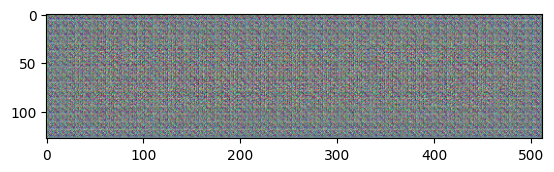

[1/100][0/10]	Loss_D: 0.1377	Loss_G: 5.2918	D(x): 0.9678	D(G(z)): 0.0960 / 0.0063


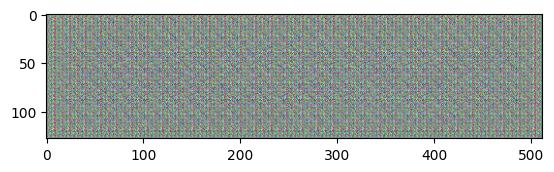

[2/100][0/10]	Loss_D: 0.0733	Loss_G: 6.4963	D(x): 0.9839	D(G(z)): 0.0539 / 0.0019


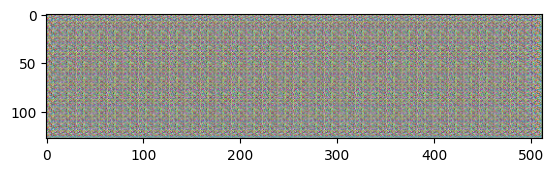

[3/100][0/10]	Loss_D: 0.0307	Loss_G: 7.3118	D(x): 0.9926	D(G(z)): 0.0228 / 0.0008


KeyboardInterrupt: 

In [7]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    batch_count = int(np.ceil(sample_count / batch_size))
    permutation = np.random.permutation(sample_count)
    for batch_idx in range(batch_count):
        print("epoch: {} \t {}/{} batch".format(epoch, batch_idx, batch_count), end="\r")
        
        batch_start = batch_idx * batch_size
        batch_end = min(sample_count, (batch_idx + 1) * batch_size)
        batch_indeces = permutation[batch_start:batch_end]
        real_batch_size = batch_end - batch_start
        
        data = dataset_t[batch_indeces]
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data
        label = torch.full((real_batch_size,), real_label, dtype=torch.float)
        if USE_CUDA:
            label = label.cuda()
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(real_batch_size, nz, noise_h, noise_w)
        if USE_CUDA:
            noise = noise.cuda()
        # Generate fake image batch with G
        fake = netG(noise)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if batch_idx % 15 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, batch_idx, batch_count, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (batch_idx == batch_count - 1 ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(fake.numpy())
            index = 0
            img = fake.numpy()[0]
            img = np.moveaxis(img, 0, -1)
            # img = np.swapaxes(img, 0, 2)
            # img = np.swapaxes(img, 0, 1)
            img = (img - img.min()) / (img.max() - img.min())
            
            plt.imshow(img)
            plt.show()

        iters += 1

In [ ]:
for imgs in img_list:
    index = 0
    img = imgs[0]
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 0, 1)
    img = (img - img.min()) / (img.max() - img.min())
    
    print(img.shape)
    plt.imshow(img)
    plt.show()